In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
ELEMENTS = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K",
            "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr",
            "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I",
            "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
            "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr",
            "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf",
            "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"]

In [3]:
LIST_OF_HIGH_TC_SUPERCONDUCTORS = [set(['Y','Ba','Cu','O']), set(['Bi','Sr','Ca','Cu','O']), set(['La','Sr','Cu','O']),
                                   set(['Ba','Co','Fe','As']), set(['Mg', 'B'])]
LIST_OF_LOW_TC_SUPERCONDUCTORS = [set(['In', 'O']),set(['Ba', 'Si']),set(['C','Li','Ca']),set(['Nb']),set(['Pb']),set(['Ta']),
                                  set(['Ti','N']), set(['C','K']), set(['Sr','Ti','O']), set(['La', 'Fe', 'P', 'O'])]
LIST_OF_NON_SUPERCONDUCTORS = [set(['Y','Fe','O']), set(['Mn', 'Bi']), set(['Fe','Cl']), set(['Co','O']),
                               set(['Ag','Mg','Sb']), set(['Ge','Pb','Sn','Te']), set(['He']), set(['O']), set(['Co','La','Sr'])]
MATERIAL_LIST = [LIST_OF_HIGH_TC_SUPERCONDUCTORS, LIST_OF_LOW_TC_SUPERCONDUCTORS, LIST_OF_NON_SUPERCONDUCTORS]

In [4]:
def is_formula(formula):
        N = len(formula)
        i = 0
        while i < N:
            if formula[i].isupper():
                if i < N - 1 and formula[i+1].islower and str(formula[i]+formula[i+1]) in ELEMENTS:
                    if i < N-2 and formula[i+2].isdigit():
                        i += 3
                    else:
                        i += 2
                elif formula[i] in ELEMENTS:
                    if i < N - 1 and formula[i+1].isdigit():
                        
                        i += 2
                    else:
                        
                        i += 1
                else:
                    return False
            else:
                return False  
            
        return True

def atom_list(formula):
        N = len(formula)
        atoms = []
        i = 0
        for i in range(N):
            if formula[i].isupper():
                if i < N - 1 and formula[i+1].islower and str(formula[i]+formula[i+1]) in ELEMENTS:
                    atoms.append(str(formula[i]+formula[i+1]))
                elif formula[i] in ELEMENTS:
                    atoms.append(formula[i])
                
        return atoms 
    
def find_top_matches(material_list, category):
    matches = []
    for i, key in enumerate(model.wv.vocab.keys()):
        if set(atom_list(key)) in material_list:
            matches.append((key, model.wv.vocab[key].count))
    
    top_matches = []
    for material in material_list:
        top_match = None
        max_count = 0
        for match, count in matches:
            if set(atom_list(match)) == material and count > max_count:
                top_match = match
                max_count = count
        top_matches.append((top_match, category))
    return top_matches

In [5]:
model = Word2Vec.load("training/models/pretrained_embeddings")

In [6]:
other_compounds = model.wv.most_similar("compound", topn = 50)
others = []
for word in list(zip(*other_compounds))[0]:
    if is_formula(word):
        others.append((word, "others"))        

In [7]:
top_high_tc = find_top_matches(LIST_OF_HIGH_TC_SUPERCONDUCTORS, "high tc")
top_low_tc = find_top_matches(LIST_OF_LOW_TC_SUPERCONDUCTORS, "low tc")
top_non_sc = find_top_matches(LIST_OF_NON_SUPERCONDUCTORS, "non sc")
total_list = top_high_tc + top_low_tc + top_non_sc + others

In [8]:
embeddings = []
words = []
categories = []
for word, category in total_list:
    categories.append(category)
    words.append(word)
    embeddings.append(model.wv[word])

In [9]:
cmap = {
    "low tc"    : "#a6cee3",
    "high tc"   : "#1f78b4",
    "non sc"    : "#b19cd9", 
    "others"    : "#8FBC8F"
}

In [10]:
embeddings = np.array(embeddings)
tsne_model_in_2d = TSNE(perplexity=5, n_components=2, init = 'pca', n_iter=3500, random_state = 3)
embeddings_in_2d = np.array(tsne_model_in_2d.fit_transform(embeddings))

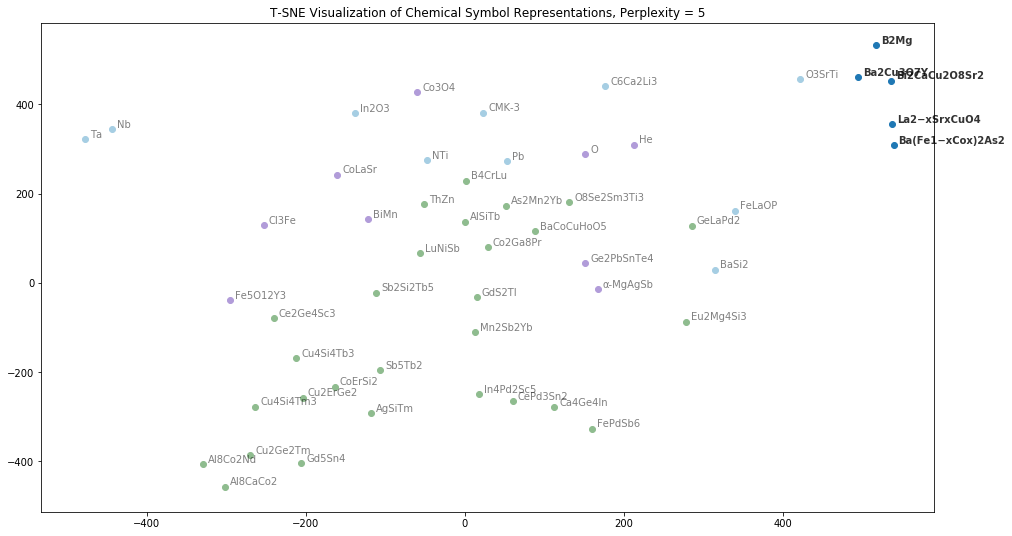

In [11]:
plt.figure(figsize = (16,9))
for i in range(len(embeddings_in_2d)):
    x = embeddings_in_2d[i][0]
    y = embeddings_in_2d[i][1]
    plt.scatter(x, y, color = cmap[categories[i]])
    if categories[i] == "high tc":
        plt.annotate(words[i], alpha=0.8, xy = (x,y), xytext = (5,2), weight = 'bold', textcoords="offset points")
    else:
        plt.annotate(words[i], alpha=0.5, xy = (x,y), xytext = (5,2), textcoords="offset points")
plt.title("T-SNE Visualization of Chemical Symbol Representations, Perplexity = 5")
plt.show()